### Part 2: Poetry generation (for real)

Let's try to generate some poetry using RNNs.

You have several choices here:

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [ ]:
import string
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [ ]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()

TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
text

['  From fairest creatures we desire increase,\n',
 "  That thereby beauty's rose might never die,\n",
 '  But as the riper should by time decease,\n',
 '  His tender heir might bear his memory:\n',
 '  But thou, contracted to thine own bright eyes,\n',
 "  Feed'st thy light's flame with self-substantial fuel,\n",
 '  Making a famine where abundance lies,\n',
 '  Thy self thy foe, to thy sweet self too cruel:\n',
 "  Thou that art now the world's fresh ornament,\n",
 '  And only herald to the gaudy spring,\n',
 '  Within thine own bud buriest thy content,\n',
 "  And tender churl mak'st waste in niggarding:\n",
 '    Pity the world, or else this glutton be,\n',
 "    To eat the world's due, by the grave and thee.\n",
 '\n',
 '  II\n',
 '\n',
 '  When forty winters shall besiege thy brow,\n',
 "  And dig deep trenches in thy beauty's field,\n",
 "  Thy youth's proud livery so gazed on now,\n",
 "  Will be a tatter'd weed of small worth held:\n",
 '  Then being asked, where all thy beaut

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

text = ''.join(text).lower()

assert len(text) == 100225, "Are you sure you have concatenated all the strings?"
assert not any([x in set(text) for x in string.ascii_uppercase]), "Uppercase letters are present"
print("OK!")

OK!


### Data loading: "Евгений Онегин"


In [ ]:
'''!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = [x.replace('\t\t', '') for x in text]'''

"!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt\n\nwith open('onegin.txt', 'r') as iofile:\n    text = iofile.readlines()\n\ntext = [x.replace('\t\t', '') for x in text]"

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here

Put all the characters, that you've seen in the text, into variable `tokens`.

In [ ]:
tokens = sorted(set(text)) + ['<sos>']

print(tokens)

['\n', ' ', '!', "'", '(', ')', ',', '-', '.', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '<sos>']


Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [ ]:
# dict <index>:<char>
# Your great code here
token_to_idx = {token: idx for idx, token in enumerate(tokens)}
# dict <char>:<index>
# Your great code here
idx_to_token = dict((v,k) for k,v in token_to_idx.items())

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [ ]:
# Your code here
text_encoded = [token_to_idx[x] for x in text]
batch_size = 256
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<sos>']

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))

In [ ]:
next(generate_chunk())

array([[38, 15,  1, ...,  1, 12, 30],
       [38,  1, 23, ..., 19, 12, 15],
       [38,  1, 12, ...,  1, 26, 31],
       ...,
       [38, 17, 29, ..., 31, 16, 10],
       [38,  0,  1, ...,  1, 24, 36],
       [38,  1, 12, ..., 30,  6,  1]])

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size,  hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.RNN = nn.RNN(input_size, hidden_size, n_layers, batch_first=True)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        input = nn.functional.one_hot(input.view(-1, 1), num_classes=self.input_size).to(torch.float32)
        output, hidden = self.RNN(input.view(-1, 1, self.input_size), hidden)
        output = self.decoder(output.view(-1, self.hidden_size))
        return output, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(self.n_layers, batch_size,  self.hidden_size, requires_grad = True)

In [ ]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def train(Chunk, n_characters, decoder, decoder_optimizer, criterion):
    hidden = decoder.init_hidden(batch_size)
    decoder.zero_grad()
    loss = 0

    Chunk = torch.tensor(chunk).type(torch.LongTensor)

    inp=[0]*seq_length
    target=[0]*seq_length
    for i in range(seq_length):
        inp[i] = Chunk[:, i]
        target[i] = Chunk[:, i+1]


    for c in range(seq_length):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c])

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / seq_length


In [ ]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005
n_characters = len(tokens)

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    chunk = next(generate_chunk())
    loss = train(chunk, n_characters, decoder, decoder_optimizer, criterion)
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 20s (100 5%) 2.1513]
 36s (200 10%) 1.9086]
 52s (300 15%) 1.7839]
 7s (400 20%) 1.6525]
 23s (500 25%) 1.6279]
 39s (600 30%) 1.5238]
 54s (700 35%) 1.5262]
 10s (800 40%) 1.5233]
 25s (900 45%) 1.4479]
 41s (1000 50%) 1.5259]
 56s (1100 55%) 1.4015]
 11s (1200 60%) 1.4208]
 26s (1300 65%) 1.3467]
 42s (1400 70%) 1.3282]
 58s (1500 75%) 1.3223]
 13s (1600 80%) 1.3791]
 28s (1700 85%) 1.4039]
 43s (1800 90%) 1.3337]
 0s (1900 95%) 1.3449]
 15s (2000 100%) 1.2939]


Plot the loss function (axis X: number of epochs, axis Y: loss function).

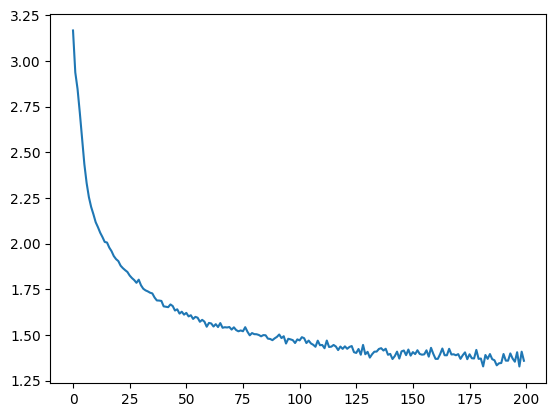

In [ ]:
# Your plot code here
import matplotlib.pyplot as plt

plt.plot(all_losses)

In [ ]:
def generate_sample(char_rnn, seed_phrase=" hello", max_length=500, temperature=1.0):
    """
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function

    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
        smaller temperature converges to the single most likely output.

    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    """

    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.init_hidden(batch_size=1)

    # feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        out, hid_state = char_rnn(x_sequence[:, i], hid_state)

    # start generating
    for _ in range(max_length - len(seed_phrase)):
        out, hid_state = char_rnn(x_sequence[:, -1], hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return "".join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [ ]:
# An example of generated text.
print(generate_sample(decoder, max_length=500, temperature=0.2))

 hellow,
  that you as from the stare my self and the stand for the strange.
    then thou art not see doth since, and thou art thy self do thee in the toothent of thee in thee as of your see,
  so my self and the stand for thee i which thee the stand is my love shall is the that which i be of the stall men sweet be world then my love the worth the strength she love as streng,
  and that thou see i love is my self thee to so shall i see the strange thee morer fight,
  when thou hast that mine ow


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

*Comment: if you wish, you can use small GPT as well (e.g. from https://github.com/karpathy/nanoGPT)*

Plot the loss function of the number of epochs. Does the final loss become better?

In [ ]:
# Your beautiful code here
class LSTM(nn.Module):
    def __init__(self, input_size,  hidden_size, output_size, n_layers=1):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.lstm = nn.LSTM(input_size, hidden_size, n_layers, batch_first=True)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        input = nn.functional.one_hot(input.view(-1, 1), num_classes=self.input_size).to(torch.float32)
        output, hidden = self.lstm(input.view(-1, 1, self.input_size), hidden) # here hidden = (h, c)
        output = self.decoder(output.view(-1, self.hidden_size))
        return output, hidden

    def init_hidden(self, batch_size):
        return (torch.zeros(self.n_layers, batch_size,  self.hidden_size, requires_grad = True),
               torch.zeros(self.n_layers, batch_size,  self.hidden_size, requires_grad = True))


In [ ]:
decoder = LSTM(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    chunk = next(generate_chunk())
    loss = train(chunk, n_characters, decoder, decoder_optimizer, criterion)
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 55s (100 5%) 2.2173]
 44s (200 10%) 1.9505]
 32s (300 15%) 1.7954]
 20s (400 20%) 1.6624]
 7s (500 25%) 1.5816]
 55s (600 30%) 1.5139]
 44s (700 35%) 1.4996]
 36s (800 40%) 1.4058]
 25s (900 45%) 1.3506]
 14s (1000 50%) 1.4501]
 2s (1100 55%) 1.3540]
 51s (1200 60%) 1.3384]
 39s (1300 65%) 1.4239]
 31s (1400 70%) 1.1708]
 30s (1500 75%) 1.2933]
 22s (1600 80%) 1.2549]
 16s (1700 85%) 1.1452]
 5s (1800 90%) 1.2096]
 55s (1900 95%) 1.2938]
 45s (2000 100%) 1.1726]


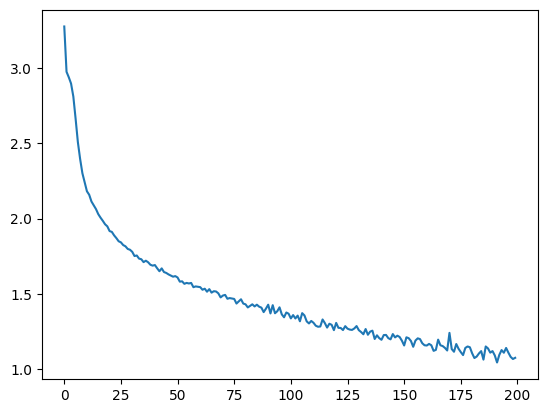

In [ ]:
plt.plot(all_losses)
plt.show()

Да финальная ошибка уменьшилась

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [ ]:
# Text generation with different temperature values here
temperatures = [0.1, 0.2, 0.5, 1.0, 2.0]
for temperarute in temperatures:
    print(generate_sample(decoder, max_length=100, temperature=temperarute))
    print('\n', "---------------------------", '\n')

 hellow'd no more warch in old thee i love.
  to true thou dost contracl did my deserving?
  the can

 --------------------------- 

 hellow'd no more warch in old thee i love.
  to breathe, stand the black shall in the self decrees


 --------------------------- 

 hellow'd not state,
  in so the self dearry meeds.
    since which they see and love lose not do no

 --------------------------- 

 hellouse one abuth that itnelss pen;
  thou my than that roblavins all forget fear,
  any nambing w

 --------------------------- 

 hellochm givn have yet,
  yet, yours motho hid but plea:
  comful true's ann wharit thy rectoon;.
 

 --------------------------- 



Текст всё равно несвязный, но больше всего слов похоже на правду при температруе 0.5

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [ ]:
# Saving and loading code here
torch.save(decoder.state_dict(), 'lstm.pth')

#loading
model = torch.load('lstm.pth', weights_only=False)

print(generate_sample(decoder, max_length=100, temperature=0.5))

 hellow'd niser shall detine in this my heart,
  and thought i sin my strength to breathe,
    for m


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a>
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch)
4. nanoGPT by Andrej Karpathy: https://github.com/karpathy/nanoGPT